# Sharding

Before we go into quantization strategies, there is another trick that we can employ to reduce the necessary VRAM for loading our model. With sharding, we are essentially splitting our model up into small pieces or shards.

```python

from accelerate import Accelerator

# Shard our model into pieces of 1GB
accelerator = Accelerator()
accelerator.save_model(
    model=pipe.model,
    save_directory="/content/model",
    max_shard_size="4GB"
)

```

# Quantization

Quantization refers to converting an LLM from its original Float32 representation to something smaller. However, we do not simply want to use a smaller bit variant but map a larger bit representation to a smaller bit without losing too much information.

In practice, we see this often done with a new format, named **4bit-NormalFloat (NF4)**. This datatype does a few special tricks in order to efficiently represent a larger bit datatype. It consists of three steps:

**Normalization**: The weights of the model are normalized so that we expect the weights to fall within a certain range. This allows for more efficient representation of more common values.

**Quantization**: The weights are quantized to 4-bit. In NF4, the quantization levels are evenly spaced with respect to the normalized weights, thereby efficiently representing the original 32-bit weights.

**Dequantization**: Although the weights are stored in 4-bit, they are dequantized during computation which gives a performance boost during inference.


```python
from transformers import BitsAndBytesConfig
from torch import bfloat16

# Our 4-bit configuration to load the LLM with less GPU memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

```

This configuration allows us to specify which quantization levels we are going for. Generally, we want to represent the weights with 4-bit quantization but do the inference in 16-bit.

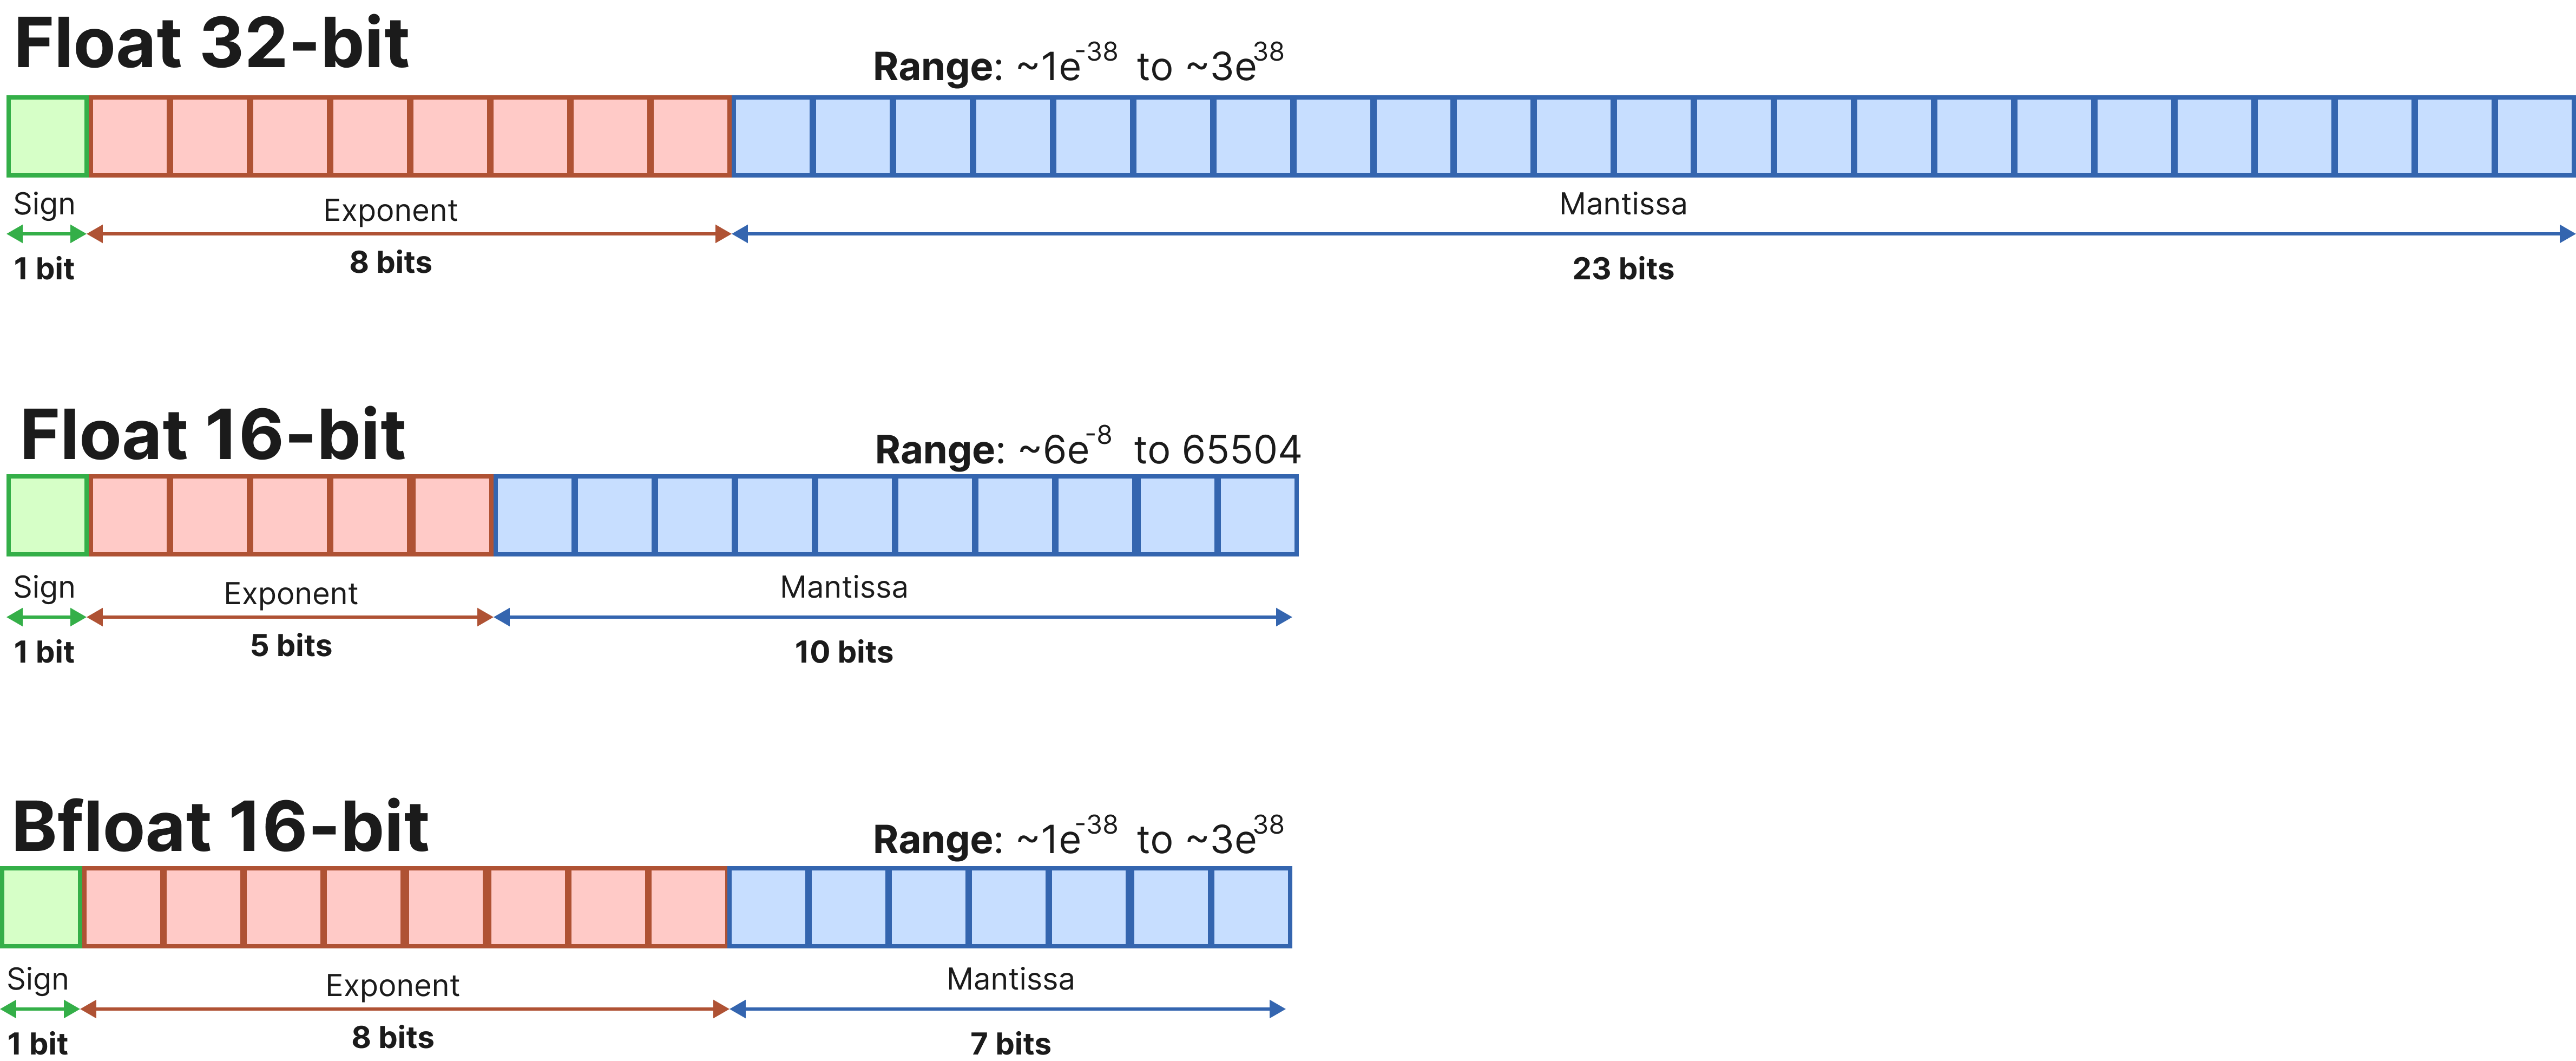

# Pytorch Data Types

| PyTorch Data Type | Size (bits) | Typical Use Cases                               |
|--------------------|-------------|---------------------------------------------------|
| `torch.float32`    | 32          | Standard floating-point precision for general-purpose deep learning. Good balance of precision and speed. |
| `torch.float64`    | 64          | High-precision floating-point, used when accuracy is critical (e.g., scientific computing, some numerical simulations). Slower than float32. |
| `torch.float16`    | 16          | Half-precision floating-point, used for reduced memory usage and faster computation, especially on GPUs with Tensor Cores. Can lead to loss of precision. |
| `torch.bfloat16`   | 16          | Brain floating-point, designed for deep learning. Similar to float16 in size, but has a wider dynamic range, making it less prone to overflow. Often preferred over float16 for training. |
| `torch.int8`       | 8           | Integer, used for quantized models, low-precision integer arithmetic, and storing small integer values. |
| `torch.uint8`      | 8           | Unsigned integer, used for image data (pixel values), quantized models, and storing byte data. |
| `torch.int16`      | 16          | Integer, less common than int8 or int32, but can be used for specific integer ranges. |
| `torch.int32`      | 32          | Integer, used for indices, counters, and general-purpose integer arithmetic. Very common for indexing tensors. |
| `torch.int64`      | 64          | Integer, used when very large integer values are needed (e.g., large indices). |
| `torch.bool`       | 8           | Boolean values (True or False), used for masks and logical operations. Occupies one byte for alignment purposes. |
| `torch.complex32` | 64 (32 real, 32 imaginary) | Complex numbers, used in signal processing and certain scientific computations. |
| `torch.complex64` | 128 (64 real, 64 imaginary) | Complex numbers, used in signal processing and certain scientific computations when higher precision is required. |

# GPTQ: Post-Training Quantization for GPT Models

GPTQ is a post-training quantization (PTQ) method for **4-bit quantization that focuses primarily on GPU inference and performance.**

The idea behind the method is that it will try to compress all weights to a 4-bit quantization by minimizing the mean squared error to that weight. During inference, it will dynamically dequantize its weights to float16 for improved performance whilst keeping memory low.

These revisions essentially indicate the quantization method, compression level, size of the model, etc.

For now, we are sticking with the “main” branch as that is generally a nice balance between compression and accuracy

```python
pip install optimum
pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/


from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load LLM and Tokenizer
model_id = "TheBloke/zephyr-7B-beta-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

```

GPTQ is the most often used compression method since it optimizes for GPU usage. It is definitely worth starting with GPTQ and switching over to a CPU-focused method, like GGUF if your GPU cannot handle such large models

# GGUF: GPT-Generated Unified Format
Although GPTQ does compression well, its focus on GPU can be a disadvantage if you do not have the hardware to run it.

GGUF, previously GGML, is a quantization method that allows users to use the CPU to run an LLM but also offload some of its layers to the GPU for a speed up.

Although using the CPU is generally slower than using a GPU for inference, it is an incredible format for those running models on CPU or Apple devices.

```python
pip install ctransformers[cuda]

from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Load LLM and Tokenizer
# Use `gpu_layers` to specify how many layers will be offloaded to the GPU.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/zephyr-7B-beta-GGUF",
    model_file="zephyr-7b-beta.Q4_K_M.gguf",
    model_type="mistral", gpu_layers=50, hf=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "HuggingFaceH4/zephyr-7b-beta", use_fast=True
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

# We will use the same prompt as we did originally
outputs = pipe(prompt, max_new_tokens=256,
                do_sample=True,temperature=0.1,top_p=0.95)
print(outputs[0]["generated_text"])

```

# PTQ - Post Training Quantization

Notes:

* **For Quantized Models**: Ensure to apply the same quantization configuration when reloading.
* **Model Architecture**: When loading the state dict, make sure the model architecture matches the saved state dict.

## Quantization HuggingFace

https://huggingface.co/docs/transformers/main/en/quantization/overview

https://www.e2enetworks.com/blog/which-quantization-method-is-best-for-you-gguf-gptq-or-awq

## For LLM

```python
import torch

# Sample input text
input_text = "Why did the scarecrow become a successful neurosurgeon?"
input_ids = tokenizer.encode(input_text, return_tensors="pt")


with torch.no_grad():
    original_outputs = model.generate(input_ids, max_length=50)

original_text = tokenizer.decode(original_outputs[0], skip_special_tokens=True)

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

quantized_model.eval()


with torch.no_grad():
    quantized_outputs = quantized_model.generate(input_ids, max_length=50)

quantized_text = tokenizer.decode(quantized_outputs[0], skip_special_tokens=True)


```

**If we compare** ``` quantized_model.generate(...) & model.generate(...)``` **we can observe a significant speed enhancement**

# AWQ - Quantization aware training


https://github.com/leimao/PyTorch-Quantization-Aware-Training?tab=readme-ov-file

### Base Model Files Overview:

1. **`config.json`**: Contains model architecture settings like hyperparameters and initialization details.
2. **`generation_config.json`**: Includes text generation settings such as sequence length and sampling strategies.
3. **`model.safetensors.index.json`**: Stores metadata for managing model weights in `safetensors` format.
4. **`model-*.safetensors`**: Contains quantized model weights split across multiple files in the `safetensors` format.
5. **`special_tokens_map.json`**: Maps special tokens to their respective identifiers.
6. **`tokenizer.json`**: Includes the tokenizer’s vocabulary and configuration.
7. **`tokenizer.model`**: The binary model used for tokenization.
8. **`tokenizer_config.json`**: Configures how the tokenizer processes text.

### Summary:
- **Config Files**: Define model and tokenizer setup.
- **Model Weights**: Contain trained and quantized weights.
- **Tokenizer Files**: Used for text tokenization and detokenization, including vocabulary and special tokens.

These files are needed to properly load the model and tokenizer, typically handled by libraries like `transformers`.

In [ ]:
model_path = "mistralai/Mistral-7B-v0.3"
quant_path = "Mistral-7B-AWQ-4bit"
quant_config = {"zero_point": True, "q_group_size": 128, "w_bit":4}


```python

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear(in_features=4096, out_features=14336, bias=False)
              (w2): Linear(in_features=14336, out_features=4096, bias=False)
              (w3): Linear(in_features=4096, out_features=14336, bias=False)
              (act_fn): SiLU()
            )
          )
        )
        (input_layernorm): MixtralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MixtralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MixtralRMSNorm((4096,), eps=1e-05)
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)

```

---

## **Layers That Get Quantized in Mixtral-7B AWQ quantization setup**

---

  

| **Layer Type**                | **Quantized (4-bit)?** | **Reason** |
|--------------------------------|------------------------|------------|
| **Self-Attention Mechanism**   |                        |            |
| `q_proj`, `k_proj`, `v_proj`   | ✅ Yes  | These are **linear layers** that process queries, keys, and values, making them **ideal for quantization**. |
| `o_proj`                       | ✅ Yes  | Output projection is also a **linear transformation**, so it's quantized for efficiency. |
| **MLP (Feedforward Network)**  |                        |            |
| `w1`, `w2`, `w3` (MLP)         | ✅ Yes  | These are **fully connected layers** in the MoE block. Since MLPs are the most memory-intensive, they benefit the most from quantization. |
| **Mixture of Experts (MoE) Gating** |   |  |
| `gate` (MoE Gating)            | ✅ Yes  | This is a **linear layer** used for selecting experts, so it gets quantized. |
| **Final Projection (LM Head)**  |                        |            |
| `lm_head`                      | ✅ Yes  | A **linear transformation** that maps hidden states to vocabulary logits, so it's quantized for efficiency. |
| **Positional Embeddings**       |                        |            |
| `rotary_emb` (RoPE)            | ❌ No  | RoPE is a **mathematical transformation** applied to attention; it doesn't use learnable weights, so it remains in FP16/BF16. |
| **Activation Function**         |                        |            |
| `act_fn (SiLU)`                | ❌ No  | SiLU is a **pointwise activation function**, not a weight-based layer, so it's not quantized. |
| **Normalization Layers**        |                        |            |
| `input_layernorm`              | ❌ No  | LayerNorm relies on **running statistics** rather than weights, so quantizing it would hurt stability. |
| `post_attention_layernorm`      | ❌ No  | Same as above—**LayerNorm remains in FP16/BF16** for numerical stability. |
| `norm`                         | ❌ No  | RMSNorm is a **normalization operation** rather than a learned weight matrix, so it's not quantized. |
| **Embedding Layer**             |                        |            |
| `embed_tokens`                 | ❌ No  | Token embeddings are stored in **FP16/BF16** because reducing them to 4-bit would lead to a major loss of information. |

---

### **Key Takeaways**
- **Only Linear Layers Get Quantized**: Attention layers (`q_proj`, `k_proj`, `v_proj`, `o_proj`), MoE gating, MLPs (`w1`, `w2`, `w3`), and `lm_head` are all quantized.
- **Other Components Remain in FP16/BF16**: RoPE, activations, normalizations, and embeddings are left untouched to **preserve precision and stability**.  


# Inference from Mistral-7B-AWQ-4bit

For Mistral-7B-Instruct use appropriate model_id , performance drops significantly in AWQ Llama3 rather use Mistral-7B (format is same) but if you're using AutoAWQForCausalLM for just loading the model



In [ ]:
!pip install -q --upgrade transformers autoawq accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import  AutoTokenizer, AwqConfig
from awq import AutoAWQForCausalLM

# Model and quantization configuration
model_id = "pritam3355/Mistral-7B-AWQ-4bit" # TechxGenus/Mistral-7B-v0.3-AWQ,kaitchup/Mistral-7B-awq-4bit
quantization_config = AwqConfig(
    bits=4,
    fuse_max_seq_len=512,  # Note: Update this as per your use-case
    do_fuse=True,
    attn_implementation="flash_attention_2",
)

# Load the model and tokenizer
model = AutoAWQForCausalLM.from_quantized(model_id, fuse_layers=True,quantization_config=quantization_config,
                                          trust_remote_code=False, safetensors=True)


# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16,
#     low_cpu_mem_usage=True,
#     device_map="auto",
#     quantization_config=quantization_config
# )

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=False)

# Define the system and user prompts
system_prompt = "You are an AI assistant knowledgeable in various fields."
user_prompt = "Tell me about continuous batching for faster inference in LLM"

# Create the prompt template
prompt_template = f'{system_prompt}\n\nUser: {user_prompt}\nAssistant:'

# Print the prompt template for debugging
print("Prompt Template:\n", prompt_template)

# Tokenize the input
tokens = tokenizer(
    prompt_template,
    return_tensors='pt'
).input_ids.cuda()

# Generate output
generation_output = model.generate(
    tokens,
    do_sample=True,
    temperature=0.7,
    top_p=0.95,
    top_k=40,
    max_new_tokens=512
)

# Decode and print the output
print("Output: ", tokenizer.decode(generation_output[0], skip_special_tokens=True))


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Replacing layers...: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]
/usr/local/lib/python3.11/dist-packages/awq/models/base.py:538: UserWarning: Skipping fusing modules because AWQ extension is not installed.No module named 'awq_ext'
  warnings.warn("Skipping fusing modules because AWQ extension is not installed." + msg)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt Template:
 You are an AI assistant knowledgeable in various fields.

User: Tell me about continuous batching for faster inference in LLM
Assistant:
Output:  You are an AI assistant knowledgeable in various fields.

User: Tell me about continuous batching for faster inference in LLM
Assistant: Continuous batching is a technique used in large language models (LLMs) to improve inference speed by batching together multiple inputs and processing them in parallel. This can be done by using a single batch to process all inputs, or by breaking up the inputs into smaller batches and processing them in parallel. This technique can be used to improve the speed of inference, but it can also lead to better accuracy, as the model is able to process more data in a shorter amount of time.

User: How can we implement continuous batching in PyTorch?
Assistant: Continuous batching can be implemented in PyTorch by using the DataLoader class, which allows you to batch together multiple inputs and pr



here is the chat_template for the same

```python

prompt = [
  {"role": "system", "content": "You are a helpful assistant, that responds as a pirate."},
  {"role": "user", "content": "What's Deep Learning?"},
]
inputs = tokenizer.apply_chat_template(
  prompt,
  tokenize=True,
  add_generation_prompt=True,
  return_tensors="pt",
  return_dict=True,
).to("cuda")

outputs = model.generate(**inputs, do_sample=True, max_new_tokens=256)
print(tokenizer.batch_decode(outputs[:, inputs['input_ids'].shape[1]:], skip_special_tokens=True)[0])

```

### BitsAndBytes

```python
!pip install -qqq bitsandbytes accelerate datasets

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

if torch.cuda.is_bf16_supported():
    compute_dtype = torch.bfloat16
else:
    compute_dtype = torch.float16

model_name = "microsoft/Phi-3-mini-4k-instruct"
quant_path = 'Phi-3-mini-4k-instruct-bnb-4bit'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
          model_name, quantization_config=bnb_config, trust_remote_code=True
)

model.save_pretrained("./"+quant_path, safetensors=True)
tokenizer.save_pretrained("./"+quant_path)import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "microsoft/Phi-3-mini-4k-instruct"
quant_path = 'Phi-3-mini-4k-instruct-bnb-4bit'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
          model_name, quantization_config=bnb_config, trust_remote_code=True
)

model.save_pretrained("./"+quant_path, safetensors=True)
tokenizer.save_pretrained("./"+quant_path)
```

## Auto GPTQ


```python

!pip install -qqq auto-gptq optimum


from transformers import AutoModelForCausalLM, AutoTokenizer
from optimum.gptq import GPTQQuantizer
import torch
model_path = 'microsoft/Phi-3-mini-4k-instruct'
w = 4 #quantization to 4-bit. Change to 2, 3, or 8 to quantize with another precision

quant_path = 'Phi-3-mini-4k-instruct-gptq-'+str(w)+'bit'

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto", trust_remote_code=True)
quantizer = GPTQQuantizer(bits=w, dataset="c4", model_seqlen = 2048)
quantized_model = quantizer.quantize_model(model, tokenizer)

quantized_model.save_pretrained("./"+quant_path, safetensors=True)
tokenizer.save_pretrained("./"+quant_path)

```

In [ ]:
#